<h1>DATA 512 Human-Centered Data Science
<h2>A1 : Data Curation

The goal of this assignment is to construct, analyze, and publish a dataset of monthly traffic on English Wikipedia from January 1 2008 through August 30 2020.We will combine data about Wikipedia page traffic from two different [Wikimedia REST API](https://www.mediawiki.org/wiki/Wikimedia_REST_API) endpoints into a single dataset, perform some simple data processing steps on the data, and then analyze the data visually.

<h2> Step 1: Gathering the data </h2>

In order to measure Wikipedia traffic from 2008-2020, as a first step, we collect data from two different API endpoints, the Legacy Pagecounts API and the Pageviews API.

* The Legacy Pagecounts API ([documentation](https://wikitech.wikimedia.org/wiki/Analytics/AQS/Legacy_Pagecounts), [endpoint](https://wikimedia.org/api/rest_v1/#/Pagecounts_data_(legacy)/get_metrics_legacy_pagecounts_aggregate_project_access_site_granularity_start_end)) provides access to desktop and mobile traffic data from December 2007 through July 2016.
* The Pageviews API ([documentation](https://wikitech.wikimedia.org/wiki/Analytics/AQS/Pageviews), [endpoint](https://wikimedia.org/api/rest_v1/#/Pageviews_data/get_metrics_pageviews_aggregate_project_access_agent_granularity_start_end)) provides access to desktop, mobile web, and mobile app traffic data from July 2015 through last month.

#### Importing the libraries required for data collection, preprocessing and visualization

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

import json
import requests
import datetime as dt

In [2]:
pd.__version__

'1.1.2'

#### Assigning the endpoint URLs

In [3]:
pagecounts = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}'

pageviews = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'

#### Creating dictionaries of required parameters to be passed in the endpoints for the two APIs

In [4]:
# parameters for getting aggregated legacy view data - desktop-site
params_pagecounts_desktop = {"project" : "en.wikipedia.org",
                 "access-site" : "desktop-site",
                 "granularity" : "monthly",
                 "start" : "2007120100",
                # for end use 1st day of month following final month of data
                 "end" : "2020090100"
                    }

# parameters for getting aggregated legacy view data - mobile-site
params_pagecounts_mobile = {"project" : "en.wikipedia.org",
                 "access-site" : "mobile-site",
                 "granularity" : "monthly",
                 "start" : "2007120100",
                # for end use 1st day of month following final month of data
                 "end" : "2020090100"
                    }

# parameters for getting aggregated current standard pageview data - desktop
params_pageviews_desktop = {"project" : "en.wikipedia.org",
                    "access" : "desktop",
                    "agent" : "user",
                    "granularity" : "monthly",
                    "start" : "2007120100",
                    # for end use 1st day of month following final month of data
                    "end" : '2020090100'
                        }

# parameters for getting aggregated current standard pageview data - mobile-web
params_pageviews_mobile_web = {"project" : "en.wikipedia.org",
                    "access" : "mobile-web",
                    "agent" : "user",
                    "granularity" : "monthly",
                    "start" : "2007120100",
                    # for end use 1st day of month following final month of data
                    "end" : '2020090100'
                        }

# parameters for getting aggregated current standard pageview data - mobile-app
params_pageviews_mobile_app = {"project" : "en.wikipedia.org",
                    "access" : "mobile-app",
                    "agent" : "user",
                    "granularity" : "monthly",
                    "start" : "2007120100",
                    # for end use 1st day of month following final month of data
                    "end" : '2020090100'
                        }

#### Defining a function that requests the API calls and save the output in a json file

The below function does the API call with the parameters and returns a dictionary of output as well as a json file

In [5]:
def create_json(endpoint,parameters,apiname,accesstype,firstmonth,lastmonth):
    """
    Function that passes the required parameters into the endpoint URLs for the two APIs and
    a) saves the output of the request in a json file and 
    b) returns the output of the request as a dictionary
    
    Input:
    endpoint   - pagecounts or pageviews
    parameters - the dictionary of parameters for each API and access type
    apiname    - One of 'pageviews' or 'pagecounts'
    accesstype - One of 'desktop-site', 'mobile-site', 'desktop', 'mobile-app', 'mobile-web'
    firstmonth - First month of the analysis (Dec 2007)
    lastmonth  - last month of the analysis (Aug 2020)
    
    Output:
    * json file saved as apiname_accesstype_firstmonth-lastmonth.json
    * a dictionary output
    
    """
    call = requests.get(endpoint.format(**parameters), headers=headers)
    response = call.json()
    with open(f'{apiname}_{accesstype}_{firstmonth}-{lastmonth}.json', 'w') as file:
        json.dump(response, file, indent=4)
    return response

#### Creating the headers for the API calls

In [6]:
headers = {
    'User-Agent': 'https://github.com/Pradeepprabhakar92',
    'From': 'prdp1992@uw.edu'
}

#### Calling the above function for each API and access type

In [7]:
monthly_pagecounts_desktop    = create_json(pagecounts, params_pagecounts_desktop,'pagecounts','desktop-site','200712','202008')
monthly_pagecounts_mobile     = create_json(pagecounts, params_pagecounts_mobile,'pagecounts','mobile-site','200712','202008')
monthly_pageviews_desktop     = create_json(pageviews, params_pageviews_desktop,'pageviews','desktop','200712','202008')
monthly_pageviews_mobile_web  = create_json(pageviews, params_pageviews_mobile_web,'pageviews','mobile-web','200712','202008')
monthly_pageviews_mobile_app  = create_json(pageviews, params_pageviews_mobile_app,'pageviews','mobile-app','200712','202008')

The above function calls will create 5 json files in the folder, 2 files corresponding to the desktop site and mobile site for Legacy Pagecounts API and 3 files corresponding to desktop, mobile-web and mobile-app for Pageviews API

<h2> Step 2: Processing the data </h2>

Given the API outputs stored as dictionaries, we perform the following in step 2
* For data collected from the Pageviews API, combine the monthly values for mobile-app and mobile-web to create a total mobile traffic count for each month.
* For all data, separate the value of timestamp into four-digit year (YYYY) and two-digit month (MM) and discard values for day and hour (DDHH).

#### Loading the json files as data frames using pandas

In [9]:
monthly_pagecounts_desktop_pd = pd.json_normalize(monthly_pagecounts_desktop['items'])
monthly_pagecounts_mobile_pd = pd.json_normalize(monthly_pagecounts_mobile['items'])
monthly_pageviews_desktop_pd = pd.json_normalize(monthly_pageviews_desktop['items'])
monthly_pageviews_mobile_web_pd = pd.json_normalize(monthly_pageviews_mobile_web['items'])
monthly_pageviews_mobile_app_pd = pd.json_normalize(monthly_pageviews_mobile_app['items'])

#### Summming up the mobile web and mobile app page views and concatenating pageviews and pagecounts into a single dataframe

In [10]:
monthly_pageviews_mobile_pd = pd.concat([monthly_pageviews_mobile_web_pd,monthly_pageviews_mobile_app_pd],ignore_index=True) \
                                .groupby(['project','agent','granularity','timestamp']) \
                                .agg({'views': sum}).reset_index()

monthly_pageviews_mobile_pd['access'] = 'mobile'

monthly_pageviews_pd = pd.concat([monthly_pageviews_desktop_pd,monthly_pageviews_mobile_pd],ignore_index=True) \
                         .rename(columns={'access':'access-site','views':'count'}) \
                         .drop(columns='agent')

monthly_overall_pd = pd.concat([monthly_pagecounts_desktop_pd,monthly_pagecounts_mobile_pd,monthly_pageviews_pd],
                               ignore_index=True).drop(columns=['project','granularity'])

#### Pivoting the dataframe based on access type with missing value imputation and renaming the columns

In [27]:
monthly_overall_pivot = monthly_overall_pd.pivot(index='timestamp',columns='access-site',values='count').fillna(0). \
                        reset_index().rename_axis(None, axis=1)

monthly_overall_pivot.iloc[:,1:] = monthly_overall_pivot.iloc[:,1:].astype(np.int64)

monthly_overall_pivot = monthly_overall_pivot.rename(columns={'desktop-site':'pagecount_desktop_views',
                                                              'mobile-site':'pagecount_mobile_views',
                                                              'desktop':'pageview_desktop_views',
                                                              'mobile':'pageview_mobile_views'})

#### Summing up the desktop views and mobile views to create total page views for both the APIs

In [28]:
monthly_overall_pivot['pagecount_all_views'] = monthly_overall_pivot.pagecount_desktop_views + \
                                                monthly_overall_pivot.pagecount_mobile_views
monthly_overall_pivot['pageview_all_views'] = monthly_overall_pivot.pageview_desktop_views + \
                                                monthly_overall_pivot.pageview_mobile_views

#### Creating year (YYYY) and month(MM) columns from timestamp

In [29]:
monthly_overall_pivot['year'] = monthly_overall_pivot.timestamp.str[:4]
monthly_overall_pivot['month'] = monthly_overall_pivot.timestamp.str[4:6]

#### Selecting only the required columns and checking the head of the final dataframe

In [30]:
en_wikipedia_traffic = monthly_overall_pivot[['year',
                                             'month',
                                             'pagecount_all_views',
                                             'pagecount_desktop_views',
                                             'pagecount_mobile_views',
                                             'pageview_all_views',
                                             'pageview_desktop_views',
                                             'pageview_mobile_views']]

en_wikipedia_traffic.head()

,year,month,pagecount_all_views,pagecount_desktop_views,pagecount_mobile_views,pageview_all_views,pageview_desktop_views,pageview_mobile_views
0,2007,12,2998331524,2998331524,0,0,0,0
1,2008,01,4930902570,4930902570,0,0,0,0
2,2008,02,4818393763,4818393763,0,0,0,0
3,2008,03,4955405809,4955405809,0,0,0,0
4,2008,04,5159162183,5159162183,0,0,0,0


#### Saving the final processed data frame as a CSV

In [31]:
en_wikipedia_traffic.to_csv('en-wikipedia_traffic_200712-202008.csv',index=False)

<h2> Step 3: Analyze the data </h2>

In this step, we will create a visualization that will track three traffic metrics: mobile traffic, desktop traffic, and all traffic (mobile + desktop) using matplotlib.

#### Concatenating year and month columns into a datetime datatype for visualization

In [32]:
en_wikipedia_traffic['date'] = en_wikipedia_traffic['year'].map(str)+ '-' +en_wikipedia_traffic['month'].map(str)
en_wikipedia_traffic['date'] = pd.to_datetime(en_wikipedia_traffic['date'], format='%Y-%m')

#### Using matplotlib to create a time series line chart for the three traffic metrics -desktop, mobile and all for the two APIs

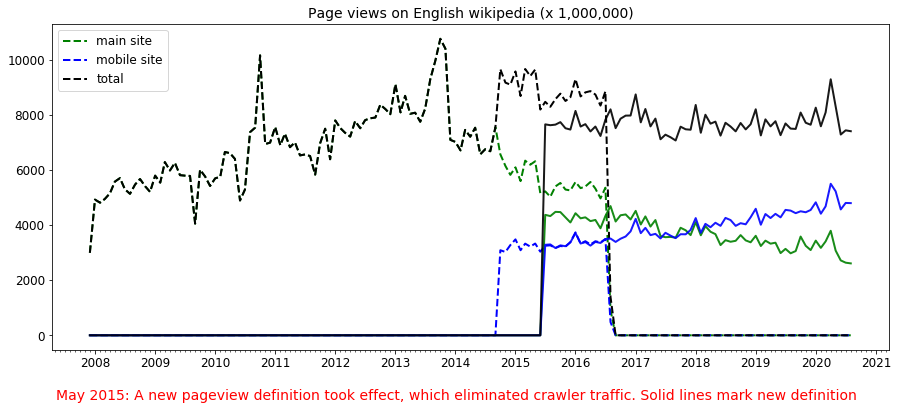

In [35]:
import matplotlib.dates as mdates

years = mdates.YearLocator()   # a ticker for the first day of every year
months = mdates.MonthLocator()  #a ticker for the first day of every month
years_fmt = mdates.DateFormatter('%Y')

fig, ax = plt.subplots(figsize=(15,6))
data = en_wikipedia_traffic
ax.plot( 'date', 'pagecount_desktop_views', data=data, color='green', linewidth=2, linestyle='dashed',label='main site')
ax.plot( 'date', 'pagecount_mobile_views', data=data, color='blue', linewidth=2, linestyle='dashed',label='mobile site')
ax.plot( 'date', 'pagecount_all_views', data=data, color='black', linewidth=2, linestyle='dashed',label='total')
ax.plot( 'date', 'pageview_desktop_views', data=data, color='green', linewidth=2,alpha=0.9,label='')
ax.plot( 'date', 'pageview_mobile_views', data=data, color='blue', linewidth=2,alpha=0.9,label='')
ax.plot( 'date', 'pageview_all_views', data=data, color='black', linewidth=2,alpha=0.9,label='')

plt.title("Page views on English wikipedia (x 1,000,000)",fontsize=14)

ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_minor_locator(months)


scale_y = 1e6
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax.yaxis.set_major_formatter(ticks_y)
# ax.set_ylim(0, 12000000000)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

caption="May 2015: A new pageview definition took effect, which eliminated crawler traffic. Solid lines mark new definition"
plt.figtext(0.5, 0.01, caption, wrap=True, horizontalalignment='center', fontsize=14,color='red')
ax.legend(fontsize=12)
plt.savefig("en_wikipedia_traffic_visualization_200712-202008.png",dpi=400)
plt.show();

### Observations

* As observed, the traffic for mobile site only started from October 2014 and has been on a steady rise since then
* The desktop traffic observed a steady rise in the traffic in the early years (between 2008 and 2014) and has been on a decline since then, in part due to the increased accessibility to mobile internet
* October 2013 observed the highest traffic till date (August 2020) with ~10.7 billion views
* In 2018, the mobile traffic overtook the dektop traffic for the first time